In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import random
import matplotlib.pyplot as plt
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                images.append(img)
    return images

def bgr_to_rgb(image): #open cv user bgr while matplot expects rgb
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
def grayscale_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
def display_random_images(images, n=2):
    random_indices = random.sample(range(len(images)), n)
    fig, axes = plt.subplots(1, n, figsize=(10, 5))

    for i, idx in enumerate(random_indices):
        rgb_image = bgr_to_rgb(images[idx])
        axes[i].imshow(rgb_image)
        axes[i].axis('off')

    plt.show()

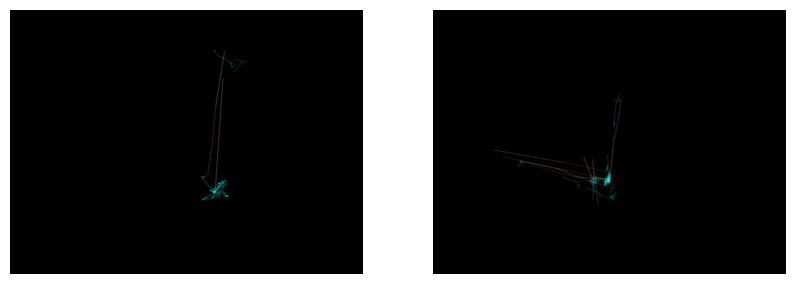

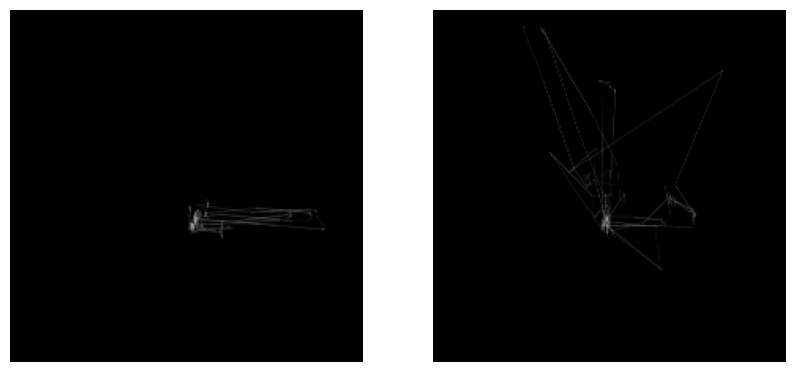

In [2]:
def preprocess_images(images):
    # Convert to grayscale and resize
    gray_images = [cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (224, 224)) for img in images]
    return [grayscale_to_rgb(img) for img in gray_images]

folder_path_class1 = r'C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\Dataset\Augmented5x\Control'
folder_path_class2 = r'C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\Dataset\Augmented5x\Patient'

# Load images from each class folder
images_class1 = load_images_from_folder(folder_path_class1)
images_class2 = load_images_from_folder(folder_path_class2)

# Visualize random 2 images from class 1
display_random_images(images_class1)

# Preprocess images and assign labels
preprocessed_images_class1 = preprocess_images(images_class1)
preprocessed_images_class2 = preprocess_images(images_class2)

X = np.array(preprocessed_images_class1 + preprocessed_images_class2)
y = np.array([0] * len(preprocessed_images_class1) + [1] * len(preprocessed_images_class2))

# Visualize random 2 images from class 1
display_random_images(preprocessed_images_class2)

# Split the data into train and test sets (70:30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
# Load the pre-trained MobileNetV3 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new layers on top of VVG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

#Display trainable layers
for i,layer in enumerate(base_model.layers):
    print(i,layer.name,layer.trainable)
    
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [4]:
# Train the model, only taining for 5 epochs
model.fit(X_train, y_train,batch_size=32, epochs=5)
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

Epoch 1/5
56/56 [==============================] - 121s 2s/step - loss: 0.5646 - accuracy: 0.7160
Epoch 2/5
56/56 [==============================] - 119s 2s/step - loss: 0.4904 - accuracy: 0.7552
Epoch 3/5
56/56 [==============================] - 137s 2s/step - loss: 0.4677 - accuracy: 0.7686
Epoch 4/5
56/56 [==============================] - 138s 2s/step - loss: 0.4461 - accuracy: 0.7843
Epoch 5/5
24/24 [==============================] - 64s 3s/step - loss: 0.4209 - accuracy: 0.8092
Test loss: 0.4209420680999756
Test accuracy: 0.8091503381729126


24/24 [==============================] - 60s 3s/step


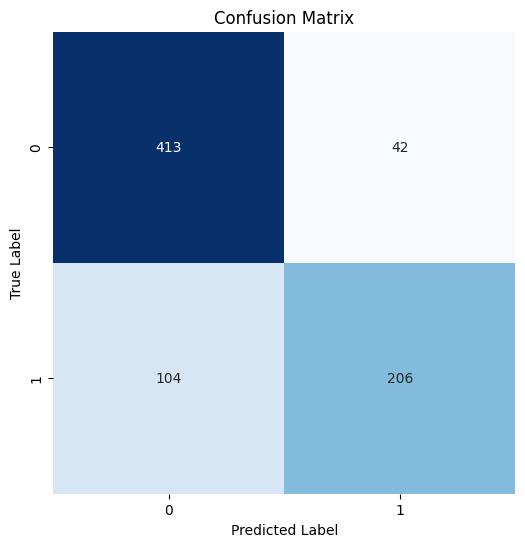

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Make predictions on the test data
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       455
           1       0.83      0.66      0.74       310

    accuracy                           0.81       765
   macro avg       0.81      0.79      0.79       765
weighted avg       0.81      0.81      0.80       765

Sensitivity: 0.66
F1 Score: 0.74


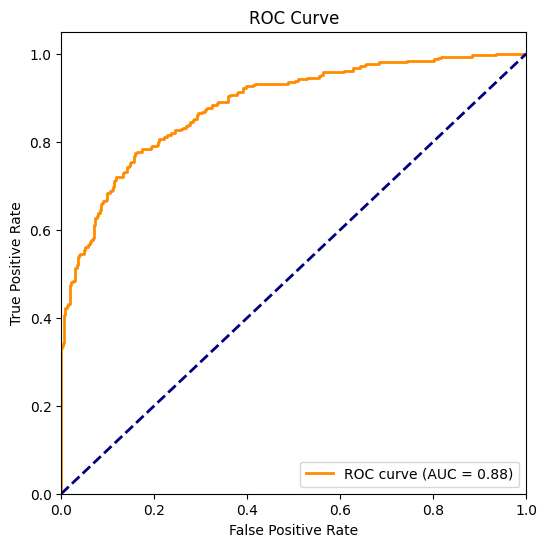

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, recall_score, f1_score
# Print the classification report
print(classification_report(y_test, y_pred))

# Calculate sensitivity (recall)
sensitivity = recall_score(y_test, y_pred)
print(f'Sensitivity: {sensitivity:.2f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.2f}')
# Calculate the false positive rate (FPR), true positive rate (TPR), and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [7]:
# Save the model to a file
model.save('VVG16.h5')

1/1 [==============================] - 0s 31ms/step


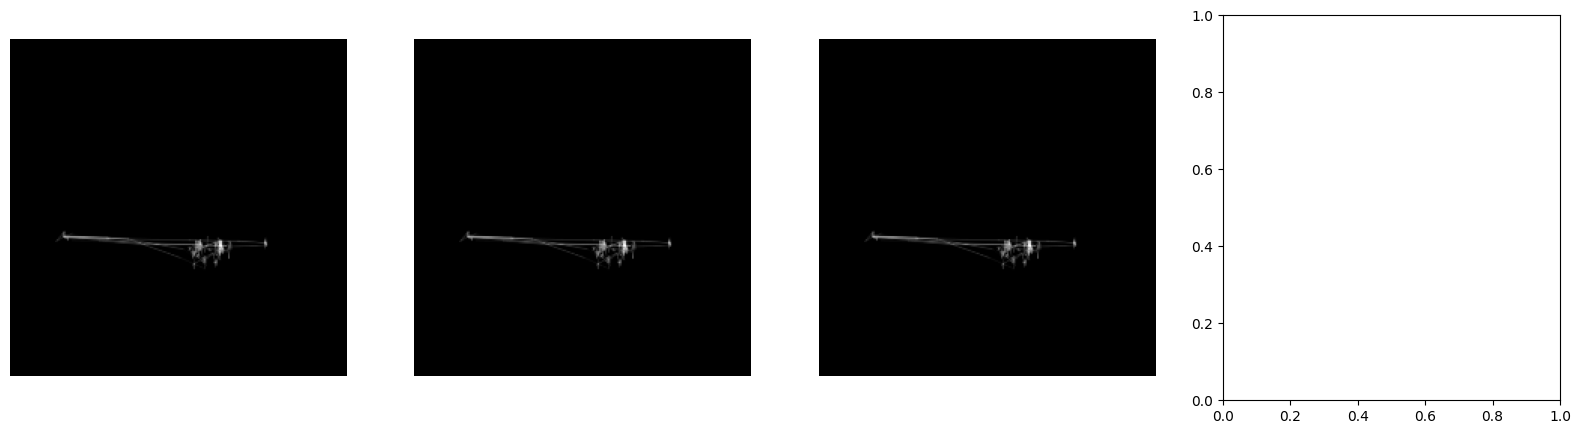

In [8]:
#Bonus visualising featue maps 
from tensorflow.keras.models import Model
# Get the first layer of the model
first_layer = model.layers[0]

# Create a new model with the same input as the original model and the output of the first layer
feature_map_model = Model(inputs=model.inputs, outputs=first_layer.output)

# Select a random preprocessed image
random_image = random.choice(X_test)

# Add a batch dimension to the image
random_image_batch = np.expand_dims(random_image, axis=0)

# Get the feature maps for the random image
feature_maps = feature_map_model.predict(random_image_batch)

# Visualize the feature maps
n_feature_maps = feature_maps.shape[-1]
n_columns = 4
n_rows = n_feature_maps // n_columns + int(n_feature_maps % n_columns != 0)

fig, axes = plt.subplots(n_rows, n_columns, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i in range(n_feature_maps):
    axes[i].imshow(feature_maps[0, :, :, i], cmap='gray')
    axes[i].axis('off')

plt.show()